In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = PowerLawSpectralModel(
    index=2.39,
    amplitude=2.54e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

PowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.390e+00   nan                nan nan  False
amplitude 2.540e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 63002 
    Total predicted counts          : 63054.93
    Total off counts                : 101975.00

    Total background counts         : 20395.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.20

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 500
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 2.16 s, sys: 19.6 ms, total: 2.18 s
Wall time: 2.18 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 62896 
    Total predicted counts          : 62991.93
    Total off counts                : 101660.00

    Total background counts         : 20332.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.18

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 62607 
    Total predicted counts          : 62926.33
    Total off counts                : 101332.00

    Total background counts         : 2

SpectrumDatasetOnOff

    Name                            : obs_20 

    Total counts                    : 63249 
    Total predicted counts          : 62917.13
    Total off counts                : 101286.00

    Total background counts         : 20257.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.23

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_21 

    Total counts                    : 62510 
    Total predicted counts          : 63069.73
    Total off counts                : 102049.00

    Total background counts         : 


SpectrumDatasetOnOff

    Name                            : obs_50 

    Total counts                    : 63233 
    Total predicted counts          : 63040.93
    Total off counts                : 101905.00

    Total background counts         : 20381.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.78

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_51 

    Total counts                    : 62875 
    Total predicted counts          : 62998.33
    Total off counts                : 101692.00

    Total background counts         :

SpectrumDatasetOnOff

    Name                            : obs_75 

    Total counts                    : 63048 
    Total predicted counts          : 63092.53
    Total off counts                : 102163.00

    Total background counts         : 20432.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.64

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_76 

    Total counts                    : 63051 
    Total predicted counts          : 62983.53
    Total off counts                : 101618.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_97 

    Total counts                    : 62831 
    Total predicted counts          : 62939.33
    Total off counts                : 101397.00

    Total background counts         : 20279.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.01

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_98 

    Total counts                    : 62830 
    Total predicted counts          : 62930.93
    Total off counts                : 101355.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_120 

    Total counts                    : 63017 
    Total predicted counts          : 62986.73
    Total off counts                : 101634.00

    Total background counts         : 20326.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.98

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_121 

    Total counts                    : 63206 
    Total predicted counts          : 63021.33
    Total off counts                : 101807.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_143 

    Total counts                    : 62802 
    Total predicted counts          : 63003.53
    Total off counts                : 101718.00

    Total background counts         : 20343.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 25.16

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_144 

    Total counts                    : 62987 
    Total predicted counts          : 62951.33
    Total off counts                : 101457.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_173 

    Total counts                    : 62783 
    Total predicted counts          : 63075.53
    Total off counts                : 102078.00

    Total background counts         : 20415.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.76

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_174 

    Total counts                    : 62784 
    Total predicted counts          : 62869.53
    Total off counts                : 101048.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_201 

    Total counts                    : 62886 
    Total predicted counts          : 62942.13
    Total off counts                : 101411.00

    Total background counts         : 20282.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.94

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_202 

    Total counts                    : 63067 
    Total predicted counts          : 62989.73
    Total off counts                : 101649.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_226 

    Total counts                    : 63001 
    Total predicted counts          : 62959.73
    Total off counts                : 101499.00

    Total background counts         : 20299.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.49

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_227 

    Total counts                    : 62985 
    Total predicted counts          : 62907.73
    Total off counts                : 101239.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_255 

    Total counts                    : 62908 
    Total predicted counts          : 62948.13
    Total off counts                : 101441.00

    Total background counts         : 20288.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.94

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_256 

    Total counts                    : 62773 
    Total predicted counts          : 63114.33
    Total off counts                : 102272.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_278 

    Total counts                    : 63285 
    Total predicted counts          : 63053.73
    Total off counts                : 101969.00

    Total background counts         : 20393.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.98

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_279 

    Total counts                    : 63098 
    Total predicted counts          : 62978.73
    Total off counts                : 101594.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_309 

    Total counts                    : 63119 
    Total predicted counts          : 62916.33
    Total off counts                : 101282.00

    Total background counts         : 20256.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.57

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_310 

    Total counts                    : 62916 
    Total predicted counts          : 63064.93
    Total off counts                : 102025.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_340 

    Total counts                    : 63041 
    Total predicted counts          : 62902.13
    Total off counts                : 101211.00

    Total background counts         : 20242.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.86

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_341 

    Total counts                    : 63058 
    Total predicted counts          : 62925.73
    Total off counts                : 101329.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_351 

    Total counts                    : 62773 
    Total predicted counts          : 62949.13
    Total off counts                : 101446.00

    Total background counts         : 20289.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.88

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_352 

    Total counts                    : 63071 
    Total predicted counts          : 62859.93
    Total off counts                : 101000.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_372 

    Total counts                    : 62919 
    Total predicted counts          : 62996.93
    Total off counts                : 101685.00

    Total background counts         : 20337.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.71

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_373 

    Total counts                    : 63047 
    Total predicted counts          : 62963.53
    Total off counts                : 101518.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_383 

    Total counts                    : 63123 
    Total predicted counts          : 62994.73
    Total off counts                : 101674.00

    Total background counts         : 20334.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.86

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_384 

    Total counts                    : 63159 
    Total predicted counts          : 63026.53
    Total off counts                : 101833.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_405 

    Total counts                    : 62886 
    Total predicted counts          : 62867.73
    Total off counts                : 101039.00

    Total background counts         : 20207.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.42

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_406 

    Total counts                    : 63053 
    Total predicted counts          : 63006.33
    Total off counts                : 101732.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_437 

    Total counts                    : 62849 
    Total predicted counts          : 63049.73
    Total off counts                : 101949.00

    Total background counts         : 20389.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.90

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_438 

    Total counts                    : 63285 
    Total predicted counts          : 62928.33
    Total off counts                : 101342.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_448 

    Total counts                    : 63058 
    Total predicted counts          : 63145.53
    Total off counts                : 102428.00

    Total background counts         : 20485.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.99

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_449 

    Total counts                    : 63318 
    Total predicted counts          : 63011.13
    Total off counts                : 101756.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_471 

    Total counts                    : 62967 
    Total predicted counts          : 62967.93
    Total off counts                : 101540.00

    Total background counts         : 20308.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.08

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_472 

    Total counts                    : 63107 
    Total predicted counts          : 62892.13
    Total off counts                : 101161.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_497 

    Total counts                    : 62912 
    Total predicted counts          : 63023.73
    Total off counts                : 101819.00

    Total background counts         : 20363.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.06

    Number of parameters            : 3
    Number of free parameters       : 2

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_498 

    Total counts                    : 62880 
    Total predicted counts          : 62957.93
    Total off counts                : 101490.00

    Total background counts         

Text(0, 0.5, 'No. of observations')

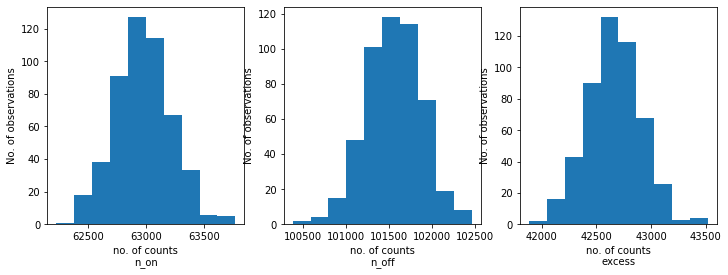

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
        }
    )

CPU times: user 1min, sys: 137 ms, total: 1min
Wall time: 1min


In [15]:
results

[{'index': 2.3830883209984433, 'amplitude': 2.5639978005732745e-12},
 {'index': 2.393723535717473, 'amplitude': 2.502033007067305e-12},
 {'index': 2.3955877206750027, 'amplitude': 2.510665795371577e-12},
 {'index': 2.393623816138676, 'amplitude': 2.5195296377566583e-12},
 {'index': 2.3970494287170374, 'amplitude': 2.53767416957465e-12},
 {'index': 2.3885708171763556, 'amplitude': 2.5312189391042396e-12},
 {'index': 2.389820095077623, 'amplitude': 2.5409470635547768e-12},
 {'index': 2.3881173942807097, 'amplitude': 2.5350500424946823e-12},
 {'index': 2.386343461033957, 'amplitude': 2.5490297127025538e-12},
 {'index': 2.384323991381617, 'amplitude': 2.5535634446736744e-12},
 {'index': 2.3898157672599303, 'amplitude': 2.552439950280229e-12},
 {'index': 2.385415752143235, 'amplitude': 2.5638690060682498e-12},
 {'index': 2.3840538565040066, 'amplitude': 2.569244995683303e-12},
 {'index': 2.396756195277325, 'amplitude': 2.5167495755682504e-12},
 {'index': 2.3881691734200317, 'amplitude': 2.5

index: 2.3901385981387238 += 0.004216264432913863


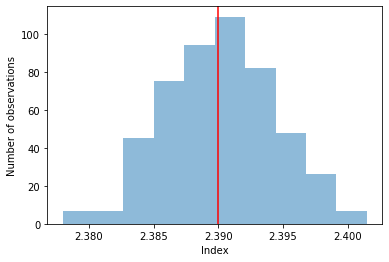

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 2.539642471708422e-12 += 1.9291876913463292e-14


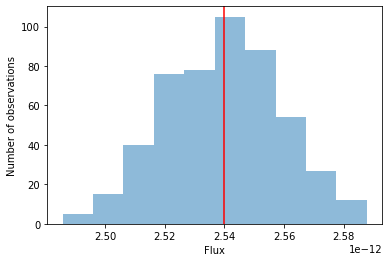

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")